In [1]:
import pandas as pd
from glob import glob
import os
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator
from scipy.stats import ttest_rel

A function to read the csv files from the **results** directory. 

In [2]:
def read_data(num_components=2):
    df_list = []
    for ts_filename in tqdm(sorted(glob(f"../results/{num_components}_component/*TS*.csv"))):
        lib_name = os.path.split(ts_filename)[-1].split("_")[0]
        ts_df = pd.read_csv(ts_filename)
        ts_df['Method'] = 'TS'
        ts_df['Reaction'] = lib_name
        df_list.append(ts_df)
        rws_filename = ts_filename.replace("TS","RWS")
        rws_df = pd.read_csv(rws_filename)
        rws_df['Method'] = 'RWS'
        rws_df['Reaction'] = lib_name     
        df_list.append(rws_df)
    combo_df = pd.concat(df_list)
    reaction_name_list = sorted(combo_df.Reaction.unique())
    reaction_num_list = range(1,len(reaction_name_list)+1)
    reaction_dict = dict(zip(reaction_name_list,reaction_num_list))
    combo_df['Reaction Id'] = [f"{num_components}cmp_{reaction_dict[x]:02d}" for x in combo_df.Reaction]
    return combo_df

Read the data for the 2- and 3-component reactions.

In [20]:
df_2_cmp = read_data(2)
df_3_cmp = read_data(3)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

A function to plot boxplot with stars showing statistical significance. 

In [6]:
def draw_boxplot(df_in, num_components, ax_in):
    ax = sns.boxplot(x='Reaction Id',y="Mean",hue="Method",data=df_in, ax=ax_in)
    ax.set_title(f"{num_components}-Component Reactions")
    ax.set_ylabel("Top 100 Recovery")
    pairs = []
    for lib_id in sorted(df_in["Reaction Id"].unique()):
        pairs.append(((lib_id, 'TS'), (lib_id, 'RWS')))

    annotator = Annotator(ax, pairs, data=df_in, x="Reaction Id", y="Mean", hue="Method")
    annotator.configure(test='t-test_paired', text_format='star', loc='inside')
    annotator.apply_and_annotate();

Make boxplots annotated with statistical significance to show the top 100 performance for each of the ten 2-component and ten 3-component reactions. 

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

2cmp_10_TS vs. 2cmp_10_RWS: t-test paired samples, P_val:3.822e-03 t=-2.957e+00
2cmp_09_TS vs. 2cmp_09_RWS: t-test paired samples, P_val:1.414e-03 t=3.276e+00
2cmp_02_TS vs. 2cmp_02_RWS: t-test paired samples, P_val:3.009e-02 t=-2.198e+00
2cmp_01_TS vs. 2cmp_01_RWS: t-test paired samples, P_val:3.898e-01 t=-8.634e-01
2cmp_03_TS vs. 2cmp_03_RWS: t-test paired samples, P_val:4.425e-01 t=-7.708e-01
2cmp_04_TS vs. 2cmp_04_RWS: t-test paired samples, P_val:1.063e-01 t=-1.629e+00
2cmp_05_TS vs. 2cmp_05_RWS: t-test paired samples, P_val:7.927e-01 t=-2.634e-01
2cmp_06_TS vs. 2cmp_06_RWS: t-test paired samples, P_val:9.824e-01 t=2.214e-02
2cmp_07_TS vs. 2cmp_07_RWS: t-test paired samples, P_val:6.589e-02 t=-1.858e+00
2cmp_08_TS vs. 2cmp_08_RWS: t-test paired samples, P_val:7.643e-01 t=3.006e-01
p-value ann

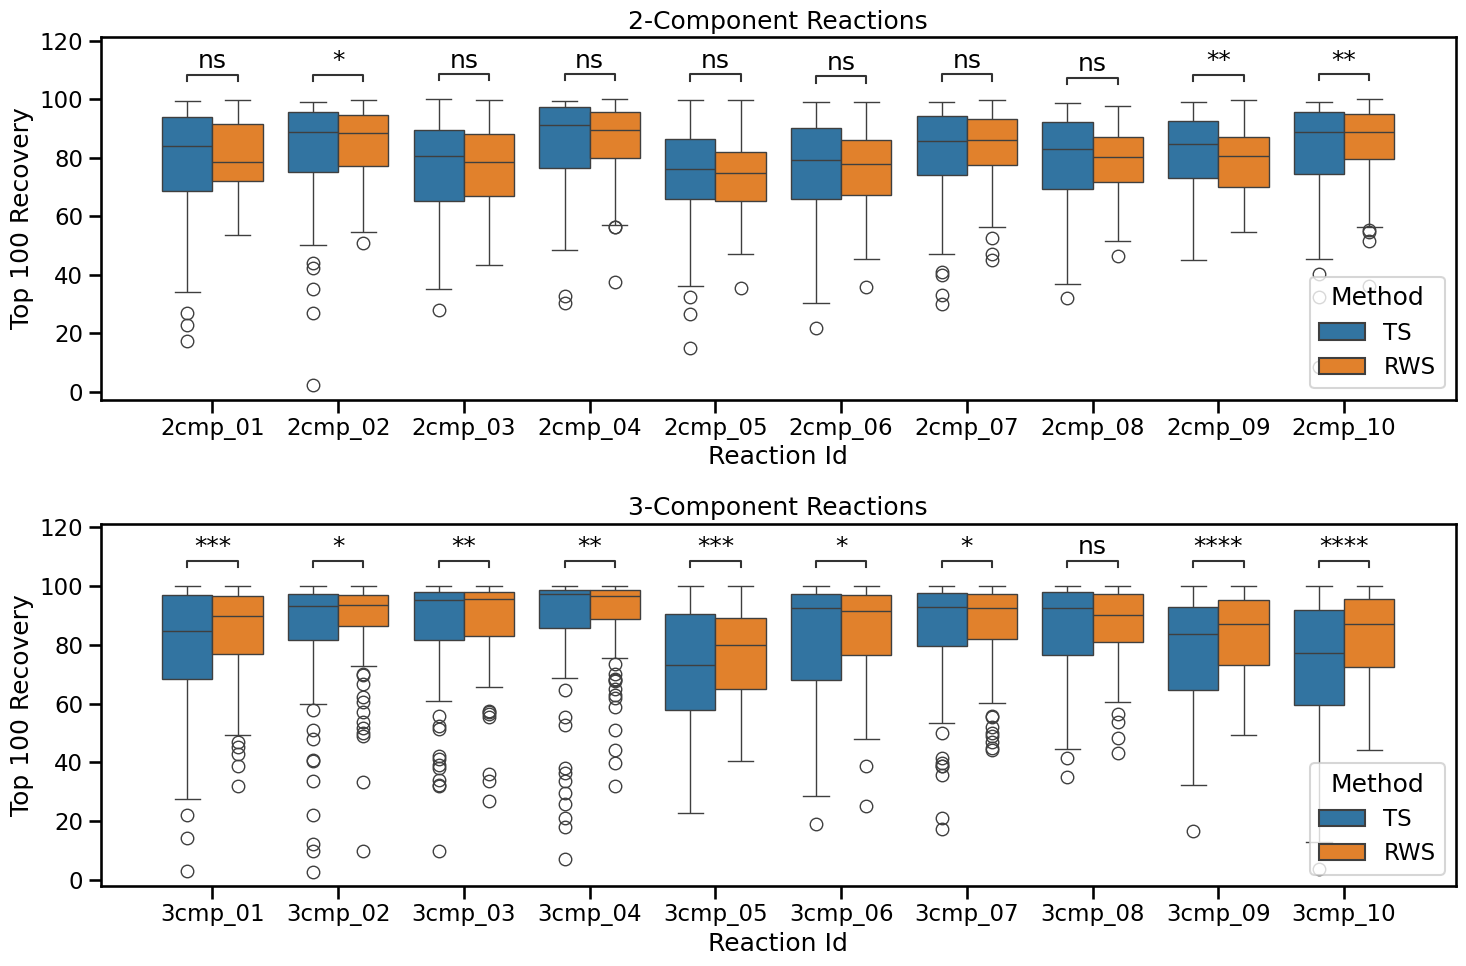

In [7]:
sns.set_context('talk')
figure, axes = plt.subplots(2,1,figsize=(15,10))
axes = axes.flatten()
draw_boxplot(df_2_cmp,2,axes[0])
draw_boxplot(df_3_cmp,3,axes[1])
plt.tight_layout()

Convert a p-value to stars showing statistical significance. 

In [11]:
def get_significance_stars(p_value):
    """
    Returns a significance annotation (ns, *, **, ***, ****) based on a p-value.

    The function uses the following legend:
    ns: 5.00e-02 < p <= 1.00e+00
    *: 1.00e-02 < p <= 5.00e-02
    **: 1.00e-03 < p <= 1.00e-02
    ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

    Parameters:
    p_value (float): The p-value to be annotated.

    Returns:
    str: The corresponding significance annotation.
    """
    if p_value <= 1.00e-04:
        return '****'
    elif p_value <= 1.00e-03:
        return '***'
    elif p_value <= 1.00e-02:
        return '**'
    elif p_value <= 5.00e-02:
        return '*'
    else:
        # This covers all p-values greater than 0.05
        return 'ns'

A function that outputs a table with mean top 100 recoveries for RWS and TS.  Also outputs a p-value from a paired t-test and stars showing statistical significance. 

In [15]:
def format_table(df_in):
    format_dict = {
    'TS': '{:.1f}', 
    'RWS': '{:.1f}',
    'p' : '{:.3f}'}
    res_list = []
    for k,v in df_in.groupby("Reaction Id"):
        res_dict = {}
        mean_list = []
        for kk,vv in v.groupby("Method"):
            res_dict[kk] = vv.Mean.mean()
            mean_list.append(vv.Mean)
        p = ttest_rel(mean_list[0],mean_list[1]).pvalue
        p_stars = get_significance_stars(p)
        res_list.append([k,res_dict["TS"],res_dict["RWS"],p,p_stars])
    res_df = pd.DataFrame(res_list,columns=["Reaction ID","TS","RWS","p","Significance"])
    styled_df = res_df.style.format(format_dict)
    return styled_df

In [17]:
format_table(df_2_cmp)

,Reaction ID,TS,RWS,p,Significance
0,2cmp_01,78.9,80.0,0.390,ns
1,2cmp_02,83.1,85.4,0.030,*
2,2cmp_03,75.8,76.6,0.443,ns
3,2cmp_04,85.0,86.3,0.106,ns
4,2cmp_05,73.7,74.0,0.793,ns
5,2cmp_06,76.5,76.5,0.982,ns
6,2cmp_07,82.3,83.9,0.066,ns
7,2cmp_08,79.2,78.9,0.764,ns
8,2cmp_09,81.9,79.3,0.001,**
9,2cmp_10,83.3,85.7,0.004,**


In [18]:
format_table(df_2_cmp)

,Reaction ID,TS,RWS,p,Significance
0,2cmp_01,78.9,80.0,0.390,ns
1,2cmp_02,83.1,85.4,0.030,*
2,2cmp_03,75.8,76.6,0.443,ns
3,2cmp_04,85.0,86.3,0.106,ns
4,2cmp_05,73.7,74.0,0.793,ns
5,2cmp_06,76.5,76.5,0.982,ns
6,2cmp_07,82.3,83.9,0.066,ns
7,2cmp_08,79.2,78.9,0.764,ns
8,2cmp_09,81.9,79.3,0.001,**
9,2cmp_10,83.3,85.7,0.004,**
